In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [2]:
#Environment and classes
!conda install ncbi-datasets-cli
!pip install biopython



from dataclasses import dataclass
from time import sleep
from Bio import SeqIO
from Bio import pairwise2
from Bio.SeqRecord import SeqRecord
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import json
import matplotlib.pyplot as plt
import os
import pandas as pd
import shutil

@dataclass
class ProteinObj:
    aaSeq: str
    protWeight: float
    associatedGeneID: int

@dataclass
class NaturalGene:
    isoforms: list
    geneID: int
    geneName: str
    organism: str
    DNASequence: str
    spliceAIDonor: list
    spliceAIReceptor: list
    energetics: dict
    chromosome: int

@dataclass
class IsoformGeneBody:
    isoformNumber: str
    associatedProtein: ProteinObj
    fullSequence: str
    codingSeq: str
    relativeAbundance: float
    geneBody: list

@dataclass
class Isoform:
    isoformNumber: str
    associatedProtein: ProteinObj
    fullSequence: str
    codingSeq: str
    relativeAbundance: float

def determineProtWeight(aaSeq: str):
    aaSeq = aaSeq.replace("X", "A")
    prot = ProteinAnalysis(aaSeq)
    return prot.molecular_weight()

ERROR: Could not find a version that satisfies the requirement miniconda (from versions: none)
ERROR: No matching distribution found for miniconda
Channels:
 - conda-forge
Platform: linux-64
Solving environment: - \ | done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.9.2

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



/usr/local/lib/python3.10/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [3]:
#User input genes
glist = []
inp = ''
while inp != 'done':
    inp = input('Enter the gene ID you want to look at: ')
    if inp != 'done':
        glist.append(inp)

Enter the gene ID you want to look at: 326
Enter the gene ID you want to look at: done


In [20]:
#Pull gene
def getSeqFrom(genomicAccessionVersion, genomicRange, sequenceName, rnas, genomes, exonBeginEndOrder):

  for genome in genomes:
    if genomicAccessionVersion == genome.id.split(":")[0]:
      range_prelim = genome.id.split(":")[1]
      range_prelim = range_prelim.replace("c", "")
      range_prelim = range_prelim.split("-")
      r1 = int(range_prelim[0])
      r2 = int(range_prelim[1])

      exonsFull = []
      for ex in exonBeginEndOrder:
        rr1 = int(ex['begin'])
        rr2 = int(ex['end'])
        ord = ex['order']

        if rr1 > rr2:
          rnaDirection = 'minus'
        else:
          rnaDirection = 'plus'

        #This condition works
        if genomicRange['orientation'] == 'plus' and rnaDirection == 'plus':
          scaledBegin = int(rr1) - r1
          scaledEnd = int(rr2) - r1
          q = genome.seq[scaledBegin:scaledEnd]
          #print(q)
          exonsFull.append(q)

        elif genomicRange['orientation'] == 'plus' and rnaDirection == 'minus':
          print("(Case B:)")
          assert abs(r2 - r1) == abs(rr2 - rr1)
          rnaSnipLen = abs(rr2 - rr1)
          scaledBegin = r1
          scaledEnd = r1 + rnaSnipLen
          q = genome.seq[scaledBegin:scaledEnd].reverse_complement()
          raise NotImplementedError
          exonsFull.append(q)

        #this condition works
        elif genomicRange['orientation'] == 'minus' and rnaDirection == 'plus':
          scaledBegin =  r1 - int(rr2)
          scaledEnd = r1 - int(rr1) + 1
          q = genome.seq[scaledBegin:scaledEnd]
          exonsFull.append(q)

        elif genomicRange['orientation'] == 'minus' and rnaDirection == 'minus':
          print("(Case D:)")
          raise NotImplementedError
          scaledBegin = int(rr1) - r1
          scaledEnd = int(rr2) - r1
          q = genome.seq[scaledBegin:scaledEnd]
          print(q)
          exonsFull.append(q)


  for rna in rnas:
    if genomicAccessionVersion == rna.id:
      print("FOUND ONE! ***")

  return exonsFull

def clearDownloadDirectory(dest: str):
  if dest in os.getcwd():
    for f in os.listdir():
      if os.path.isfile(f):
        os.remove(f)
      else:
        shutil.rmtree(f)
      #os.remove(os.path.join(dest, f))
  else:
    raise NotImplementedError

"""
def clearDownloadDirectory(dest: str):
  if dest in os.getcwd():
    for f in os.listdir():
      if os.path.isfile(f):
        os.remove(f)
      else:
        shutil.rmtree(f)
      #os.remove(os.path.join(dest, f))
  else:
    raise NotImplementedError
"""


def downloadGenePackagesAndProcess(gene_ids, data_directory):
    '''Download a gene package and put it into a NaturalGene object. Save to RefGenes/NHGenes'''
    #Uses a method found here: https://sundararamanp.medium.com/a-relatively-faster-approach-for-reading-json-lines-file-into-pandas-dataframe-90b57353fd38
    returnGenes = []
    if not os.path.exists(os.path.join(os.getcwd(),data_directory)):
        os.makedirs(data_directory)
    %cd $data_directory
    for gene_id in gene_ids:
      #%ls
      #if "NCBIDownload" not in os.getcwd():
      #  %cd $data_directory
      #  %cd NCBIDownload
      fnamezip = str(gene_id) + r'.zip'
      fname = str(gene_id)
      argg = r'gene,rna,protein,cds,3p-utr,5p-utr,product-report'
      !datasets download gene gene-id $gene_id --filename $fnamezip --include $argg --no-progressbar
      sleep(3)
      !unzip -o $fnamezip -d $fname

      # Check if the file exists before attempting to read
      rna_path = os.path.join(fname, 'ncbi_dataset', 'data', 'rna.fna')
      data_path = os.path.join(fname, 'ncbi_dataset', 'data', 'data_report.jsonl')
      pro_path = os.path.join(fname, 'ncbi_dataset', 'data', 'protein.faa')
      futr_path = os.path.join(fname, 'ncbi_dataset', 'data', '5p_utr.fna')
      tutr_path = os.path.join(fname, 'ncbi_dataset', 'data', '3p_utr.fna')
      cds_path = os.path.join(fname, 'ncbi_dataset', 'data', 'cds.fna')
      gene_path = os.path.join(fname, 'ncbi_dataset', 'data', 'gene.fna')
      prodrep_path = os.path.join(fname, 'ncbi_dataset', 'data', 'product_report.jsonl')

      print("Checking RNA")
      if os.path.exists(rna_path):
          rnas = []
          for record in SeqIO.parse(rna_path, 'fasta'):
              rnas.append(record)
      else:
          print("Error: 'rna.fna' not found in the directory.")

      print(r"Checking 5'UTR")
      if os.path.exists(futr_path):
          futrs = []
          for record in SeqIO.parse(futr_path, 'fasta'):
              futrs.append(record)
      else:
          print("Error: '5p_utr.fna' not found in the directory.")

      print(r"Checking cds")
      if os.path.exists(cds_path):
          cdss = []
          for record in SeqIO.parse(cds_path, 'fasta'):
              cdss.append(record)
      else:
          print("Error: 'cds.fna' not found in the directory.")

      print(r"Checking 3'UTR")
      if os.path.exists(tutr_path):
          tutrs = []
          for record in SeqIO.parse(tutr_path, 'fasta'):
              tutrs.append(record)
      else:
          print("Error: '3p_utr.fna' not found in the directory.")

      print("Checking proteins")
      if os.path.exists(pro_path):
          proteins = []
          for record in SeqIO.parse(pro_path, 'fasta'):
              proteins.append(record)
      else:
          print("Error: 'protein.faa' not found in the directory.")

      print("Checking genome")
      if os.path.exists(gene_path):
          genomes = []
          for record in SeqIO.parse(gene_path, 'fasta'):
              genomes.append(record)
      else:
          print("Error: 'gene.fna' not found in the directory.")

      print("Checking JSON")
      if os.path.exists(data_path):
          with open(data_path) as f:
            lines = f.read().splitlines()
          df_inter = pd.DataFrame(lines)
          df_inter.columns = ['json_element']
          df_inter['json_element'].apply(json.loads)
          df_final = pd.json_normalize(df_inter['json_element'].apply(json.loads))
      else:
          print("Error: 'data_report.jsonl' not found in the directory.")


      print("Checking product report")
      if os.path.exists(prodrep_path):
          with open(prodrep_path) as f:
            lines = f.read().splitlines()
          df_inter1 = pd.DataFrame(lines)
          df_inter1.columns = ['json_element']
          df_inter1['json_element'].apply(json.loads)
          df_final1 = pd.json_normalize(df_inter1['json_element'].apply(json.loads))
      else:
          print("Error: 'product_report.jsonl' not found in the directory.")

      print("Beginning processing for gene " + str(gene_id))

      gSeq = str(genomes[0].seq)
      geneName = df_final['symbol'][0]
      desc = df_final['description'][0]
      organism = df_final['commonName'][0]
      chromosome = df_final['chromosomes'][0]

      if 'synonyms' in df_final:
        synonyms = df_final['synonyms'][0]
      else:
        synonyms = None
      try:
        isoforms = df_final1['transcripts'][0]
      except:
        continue
      try:
        orient = df_final['orientation'][0]
      except:
        display(df_final)
        raise NotImplementedError

      isoSet = []
      exonSets = []
      for iso in isoforms:
        if 'name' in iso:
          isoformNumber = iso['name'].replace('transcript variant ', '')
        else:
          isoformNumber = -1

        #Transcripts labeled with an X are computationally predicted but not experimentally validated
        try:
          if "X" in isoformNumber:
            continue
        except TypeError:
            pass

        if len(isoforms) == 1:
          isoformNumber = 1

        if 'protein' in iso:
          tmp = iso['protein']
          protFile = tmp['accessionVersion']
          for p in proteins:
            if protFile in p.id:
              pseq = p.seq
              pweight = determineProtWeight(str(pseq))
              associatedProtein = ProteinObj(str(pseq), pweight, gene_id)
        else:
          associatedProtein = ProteinObj(str(""), 0.0, gene_id)

          #associatedProtein = iso['protein']
        geneAccession = iso['accessionVersion']
        if 'cds' in iso:
          cdsAccession = iso['cds']['accessionVersion']
          cds_temp = iso['cds']
          rng_temp = cds_temp['range']
          rng_temp = rng_temp[0]
          cdsRange = [rng_temp['begin'], rng_temp['end']]
        else:
          cdsRange = [-1,-1]
        if 'ensemblTranscript' in iso:
          ensemblTranscript = iso['ensemblTranscript']
        geneLocs = iso['genomicLocations']

        #print("There are ", str(len(geneLocs)), " genomic location sets in ", geneName, " : isoform ", isoformNumber)
        for gLocSet in geneLocs:
          if 'exons' not in gLocSet:
            continue
          exonBeginEndOrder = gLocSet['exons']
          genomicAccessionVersion = gLocSet['genomicAccessionVersion']
          genomicRange = gLocSet['genomicRange']
          sequenceName = gLocSet['sequenceName']
          exons = getSeqFrom(genomicAccessionVersion, genomicRange, sequenceName, rnas, genomes, exonBeginEndOrder)
          exSupp = []
          for ex in exons:
            distFromStart = list(range(0, len(ex)))
            exSupp.append({"seq": str(ex), "distFromStart": str(distFromStart)})
          exonSets.append(exSupp)
        cdsSet = []
        for exSet in exonSets:
          cds = ''
          for ex in exSet:
            cds += ex['seq']
          cdsSet.append(cds)

        assert len(cdsSet) == len(exonSets)
        for codingSeq in cdsSet:
          relativeAbundance = -1
          igb = IsoformGeneBody(isoformNumber, associatedProtein, '', str(codingSeq), relativeAbundance, exSupp)
          isoSet.append(igb)


        refinedIsos = []
        for iso in isoSet:
          if iso.geneBody != []:
            #Eliminate non-unique isoforms
            if iso not in refinedIsos:
              refinedIsos.append(iso)
        isoSet = refinedIsos
        refinedIsos = []
        protSeqs = []
        for iso in isoSet:
          if iso.geneBody != []:
            #Eliminate non-unique isoforms
            if str(iso.associatedProtein.aaSeq) not in protSeqs:
              protSeqs.append(str(iso.associatedProtein.aaSeq))
              refinedIsos.append(iso)
        isoSet = refinedIsos

        refinedIsos = []
        exonSeqs = []
        for iso in isoSet:
          if iso.geneBody != []:
            #Eliminate non-unique isoforms
            linked = ''
            for exon in iso.geneBody:
              linked += exon['seq']
            if linked not in exonSeqs:
              exonSeqs.append(linked)
              refinedIsos.append(iso)
      ng = NaturalGene(isoSet, gene_id, geneName, organism, gSeq, [], [], {}, chromosome)
      returnGenes.append(ng)
      clearDownloadDirectory(data_directory)
    while data_directory in os.getcwd():
        %cd ..
    return returnGenes

In [21]:
#Process
def energeticsDict(dinuc: str):
  '''Returns the dinucleotide energetics dictionary in supplemental table: https://academic.oup.com/nar/article/49/5/2674/6148175'''
  dinuc_to_col = {"AA": 0, "AT": 1, "AG": 3, "AC": 2,
                  "TA": 4, "TT": 0, "TG": 8, "TC": 7,
                  "GA": 7, "GT": 2, "GG": 6, "GC": 9,
                  "CA": 8, "CT": 3, "CG": 5, "CC": 6}
  try:
    col = dinuc_to_col[dinuc] + 1
  except:
    print("dinuc: ", dinuc)
    raise NotImplementedError

  xDisp = ["X Disp.", -0.246, -0.178, -0.031, 0.486, 0.102, 0.705, 0.585, -0.158 ,0.312 ,0.593]
  ydisp = ["Y Disp.", 0.004 ,-0.026, -0.051, -0.029, -0.286 ,0.060 ,-0.078, 0.080, -0.068 ,0.083]
  inclination = ["Inclination", -0.614 ,-0.260, 0.680, 1.825, 0.547, 2.911, 9.909, 0.526, 3.005, 0.365]
  tip = ["Tip", 0.597, 0.461, 2.510, 3.723, -0.766, 0.303, 3.128, 0.752, 0.175, 2.507]
  axBend = ["Ax-Bend", 1.422, 1.213, 1.250, 1.652, 1.471, 1.489, 2.586, 1.178, 1.055, 1.244]
  shear = ["Shear", 0.128, 0.014, 0.055, -0.064, 0.026, 0.355 ,1.224 ,0.050, -0.002, 0.021]
  stretch = ["Stretch", -0.180, -0.134, -0.125, -0.168, -0.177, -0.358, -1.123, -0.199, -0.149, -0.137]
  stagger = ["Stagger", 0.121, 0.147, 0.573, -0.146, 0.085, 0.561, 1.670, 0.215, 0.156, 0.284]
  buckle = ["Buckle", -1.482, 0.279, -5.579, -0.850, -0.326, 2.413, 8.842, -1.169, 0.076, -0.983]
  propel = ["Propel", -15.308, -16.536, -9.838, -11.734, -14.037, -3.280, 5.707, -13.135, -10.824, -10.443]
  opening = ["Opening", 3.159, 4.110, 2.110, -3.668, 3.305, -0.849, 5.719, 0.943, 2.073, -1.116]
  shift = ["Shift", -0.110, -0.060, -0.120, -0.270, -0.050, 0.240, 0.380 ,0.040 ,-0.070, -0.280]
  slide = ["Slide", -0.200, -0.440, 0.730, 0.210, 0.370, 0.680, 0.710, -0.200, 0.520, 0.170]
  rise = ["Rise", 3.250, 3.310, 3.660, 3.020, 3.390, 3.330, 2.960, 3.320, 3.290, 3.350]
  tilt = ["Tilt", 0.630, -0.900, -4.750, 3.690, -2.710, 1.750, -1.620, 2.210, -3.270, -2.680]
  roll = ["Roll", -0.080, -2.620, -0.600, -7.270, 1.740, 4.290, -2.550, 2.690, 1.540, -5.280]
  twist = ["Twist", 35.670, 33.420, 34.790, 31.000, 32.050, 37.380, 29.490, 37.740, 36.740, 31.090]
  hRise = ["H-Rise", 3.270, 3.330, 2.970, 3.060, 3.410, 3.330, 2.730, 3.330, 3.210, 3.290]
  hTwist = ["H-Twist", 35.560, 33.680, 37.600, 19.060, 32.000, 39.100, 31.570, 37.810, 37.250, 30.560]
  alpha = ["Alpha", -55.550, -51.913, -45.474, -36.214, -50.820, -43.178, -38.322, -42.611, -52.023, -48.267]
  beta = ["Beta", 51.044, 59.981 ,42.118, 36.155, 29.230 ,57.555, 39.807, 54.835, 41.346, 36.968]
  gamma = ["Gamma", 50.772, 47.175, 51.861, 43.870, 53.740, 51.502, 44.997, 53.374, 35.389, 36.646]
  delta = ["Delta", 128.408, 125.847, 126.878, 129.955, 127.846, 132.616, 129.998, 131.432, 131.452, 129.951]
  epsilon = ["Epsilon", -5.924, -31.230, -34.321, -43.587, -37.772, -67.013, -56.716, -8.081, -75.781, -70.502]
  zeta = ["Zeta", -96.656, -93.609, -55.767, -34.570, -61.970, -62.643, -61.650, -94.004, -60.380, -63.978]
  chi = ["Chi", -110.254, -113.738, -116.547, -88.341, -106.740, -106.586, -103.913, -110.983, -91.503, -109.979]
  phase = ["Phase", 118.784, 107.855, 106.334, 73.080, 119.920, 103.300, 96.172, 118.188, 73.933, 84.877]
  amplitude = ["Amplitude", 38.996, 40.016, 38.650, 38.941, 37.824, 37.951, 37.361, 37.945, 38.744, 38.594]
  hydrogenBondingEnergy = ["Hydrogen Bonding Energy",-5.440, -5.350, -7.140, -6.270, -5.830, -8.050, -8.480, -7.800, -7.010, -8.720]
  stackingEnergy = ["Stacking Energy", -26.710, -27.200, -27.730, -26.890, -26.900, -27.930, -26.280, -26.780, -27.150, -28.130]
  solvationEnergy = ["Solvation Energy", -171.840, -173.700, -171.110, -174.930, -174.350, -176.880, -166.760, -167.600, -179.010, -165.580]

  rdict = {xDisp[0]: xDisp[col],
           ydisp[0]: ydisp[col],
           inclination[0]: inclination[col],
           tip[0]: tip[col],
           axBend[0]: axBend[col],
           shear[0]: shear[col],
           stretch[0]: stretch[col],
           stagger[0]: stagger[col],
           buckle[0]: buckle[col],
           propel[0]: propel[col],
           opening[0]: opening[col],
           shift[0]: shift[col],
           rise[0]: rise[col],
           tilt[0]: tilt[col],
           roll[0]: roll[col],
           twist[0]: twist[col],
           hRise[0]: hRise[col],
           hTwist[0]: hTwist[col],
           alpha[0]: alpha[col],
           beta[0]: beta[col],
           gamma[0]: gamma[col],
           delta[0]: delta[col],
           epsilon[0]: epsilon[col],
           zeta[0]: zeta[col],
           chi[0]: chi[col],
           phase[0]: phase[col],
           amplitude[0]: amplitude[col],
           hydrogenBondingEnergy[0]: hydrogenBondingEnergy[col],
           stackingEnergy[0]: stackingEnergy[col],
           solvationEnergy[0]: solvationEnergy[col]
           }
  #print(dinuc)
  #print(rdict)
  #raise NotImplementedError
  return rdict

In [28]:
def runEnergeticsRightSide(geneObj : NaturalGene, windowSize = 25):
  '''Return a dictionary with lists of energy values for each position along the window number line'''
  #Get a list of dinucleotides
  dinucs = [geneObj.DNASequence[i:i+2] for i in range(0, len(geneObj.DNASequence) -1, 1)]
  #Get the list of energy values for each dinuc
  dinucEnergies = []
  for dinuc in dinucs:
    dinucEnergies.append(energeticsDict(dinuc))
  dinucEnergiesStandardized = []
  for i in range(0,len(geneObj.DNASequence)):
    #For the first one, just take the first energy measurement
    if i == 0:
      dinucEnergiesStandardized.append(dinucEnergies[i])
    #For the last one, just take the last energy measurement
    elif i == len(geneObj.DNASequence)-1:
      dinucEnergiesStandardized.append(dinucEnergies[i-1])
      break
    #for all others, average left and right
    else:
      #average the left and right dicts
      lDict = dinucEnergies[i-1]
      rDict = dinucEnergies[i]
      avDict = {}
      for key in lDict.keys():
        #print("lDict at " + str(key) + " is " + str(lDict[key]), " for position " + str(i) + " in a ", str(len(geneObj.DNASequence)), "DNASequence")
        #print("rDict at " + str(key) + " is " + str(rDict[key]), " for position " + str(i) + " in a ", str(len(geneObj.DNASequence)), "DNASequence")
        avDict[key] = (float(lDict[key]) + float(rDict[key]))/2
      dinucEnergiesStandardized.append(avDict)
  #print(len(dinucEnergiesStandardized))
  #print(len(geneObj.DNASequence))
  assert len(dinucEnergiesStandardized) == len(geneObj.DNASequence)

  #Split it up into windows
  numWindows = len(geneObj.DNASequence) - windowSize
  windowEnergyAverages = []
  for i in range(0,windowSize):
    windowEnergyAverages.append("N")
  #for each window
  for i in range(0, numWindows):
    #get the subset of energy dicts inside the window
    windowEnergies = [dinucEnergiesStandardized[i+j] for j in range(0,windowSize)]

    assert len(windowEnergies) == windowSize
    #declare a blank energy dict
    windowEnergyRight = {}
    #for each key in a dinuc energy dict
    for key in windowEnergies[0].keys():
      windowEnergyRight[key] = []
      #for each of the dinuc energy dicts in the window
      vals = []
      for window in windowEnergies:
        vals.append(window[key])
      #add the values
      val = 0
      for v in vals:
        val += v
      windowEnergyRight[key].append(val/windowSize)
    windowEnergyAverages.append(windowEnergyRight)
  assert len(windowEnergyAverages) == len(geneObj.DNASequence)

  return windowEnergyAverages


def runEnergeticsLeftSide(geneObj : NaturalGene, windowSize = 25):
  '''Return a dictionary with lists of energy values for each position along the window number line'''
  #Get a list of dinucleotides
  dinucs = [geneObj.DNASequence[i:i+2] for i in range(0, len(geneObj.DNASequence) -1, 1)]
  #Get the list of energy values for each dinuc
  dinucEnergies = []
  for dinuc in dinucs:
    dinucEnergies.append(energeticsDict(dinuc))
  dinucEnergiesStandardized = []
  for i in range(0,len(geneObj.DNASequence)):
    #For the first one, just take the first energy measurement
    if i == 0:
      dinucEnergiesStandardized.append(dinucEnergies[i])
    #For the last one, just take the last energy measurement
    elif i == len(geneObj.DNASequence)-1:
      dinucEnergiesStandardized.append(dinucEnergies[i-1])
      break
    #for all others, average left and right
    else:
      #average the left and right dicts
      lDict = dinucEnergies[i-1]
      rDict = dinucEnergies[i]
      avDict = {}
      for key in lDict.keys():
        avDict[key] = (lDict[key] + rDict[key])/2
      dinucEnergiesStandardized.append(avDict)
  #print(len(dinucEnergiesStandardized))
  #print(len(geneObj.DNASequence))
  assert len(dinucEnergiesStandardized) == len(geneObj.DNASequence)

  #Split it up into windows
  numWindows = len(geneObj.DNASequence) - windowSize
  windowEnergyAverages = []

  p = len(geneObj.DNASequence)
  for i in range(0,p-windowSize):
    #get the subset of energy dicts inside the window
    windowEnergies = [dinucEnergiesStandardized[i+j] for j in range(0,windowSize)]

    assert len(windowEnergies) == windowSize
    #declare a blank energy dict
    windowEnergyLeft = {}
    #for each key in a dinuc energy dict
    for key in windowEnergies[0].keys():
      windowEnergyLeft[key] = []
      #for each of the dinuc energy dicts in the window
      vals = []
      for window in windowEnergies:
        vals.append(window[key])
      #add the values
      val = 0
      for v in vals:
        val += v
      windowEnergyLeft[key].append(val/windowSize)
    windowEnergyAverages.append(windowEnergyLeft)
  for i in range(0,windowSize):
    windowEnergyAverages.append("N")
  assert len(windowEnergyAverages) == len(geneObj.DNASequence)
  return windowEnergyAverages

def runEnergetics(geneObj : NaturalGene, windowSize = 25):
  '''Return a dictionary with lists of energy values for each position along the window number line'''
  geneObj.energetics['right'] = runEnergeticsRightSide(geneObj, windowSize=windowSize)
  geneObj.energetics['left'] = runEnergeticsLeftSide(geneObj, windowSize=windowSize)

def exonLocations(geneObj : NaturalGene):
  '''Adds the beginning and end numbers to the NaturalGene's exons in the isoform's gene body'''
  print(len(geneObj.DNASequence))
  for iso in geneObj.isoforms:
    for exon in iso.geneBody:
      #get left and right values of the exon in the DNASeq by doing an alignment
      print(exon)

      ##########could turn this into a list for all dna seqs associated
      strt = geneObj.DNASequence.find(exon['seq'])
      if strt != -1:
        print("exon not found")
        raise NotImplementedError
        exon['start'] = strt
        exon['end'] = strt + len(exon['seq'])
      else:
        #change to semi global
        alignments = pairwise2.align.localms(geneObj.DNASequence, exon['seq'], 2, 1, -1, 0)
        #sort alignments by score
        alignments.sort(key=lambda x: x.score)
        alignment = alignments[0]
        print("Len DNA Seq")
        print(len(geneObj.DNASequence))
        print("Start" , alignment[3])
        print("End", alignment[4])
        print("Length of exon: ", len(exon['seq']))
        print("Diff in start and end: ", abs(alignment[3]-alignment[4]) )
        print("&&&&&&")
        #raise NotImplementedError
        exon['start'] = alignment[3]
        exon['end'] = alignment[4]
  return geneObj

In [30]:
#Display
def visualizeEnergetics(geneObj: NaturalGene, energyKey: str, lRange = 0, rRange = 0):
  x_vals = range(0, len(geneObj.DNASequence))
  y_valsr = []
  r = geneObj.energetics['right']
  l = geneObj.energetics['left']
  print(l[0])
  print(r[0])

  for i in x_vals:
    # Check if the element is a dictionary before accessing energyKey
    if isinstance(r[i], dict):
      dctr = r[i]
      if energyKey in dctr:
        y_valsr.append(*dctr[energyKey])
      else:
        if i == 0:
          y_valsr.append(0)
        else:
          y_valsr.append(y_valsr[i-1])
      #y_vals.append(geneObj.energetics[i][energyKey])
    elif r[i] == "N":
      y_valsr.append(0)
    else:
      raise NotImplementedError
  y_valsl = []
  for i in x_vals:
    # Check if the element is a dictionary before accessing energyKey
    if isinstance(l[i], dict):
      dctl = l[i]
      if energyKey in dctl:
        y_valsl.append(*dctl[energyKey])
      else:
        if i == 0:
          y_valsl.append(0)
        else:
          y_valsl.append(y_valsl[i-1])
    elif l[i] == "N":
      y_valsl.append(0)
    else:
      raise NotImplementedError
      y_valsl.append(0)
  #Draw vertical lines where splice sites start and end
  starts = []
  ends = []
  iso = geneObj.isoforms[0]
  print("iso")
  print(iso)
  for exon in iso.geneBody:
    #get left and right values of the exon in the DNASeq by doing an alignment
    print(exon)
    alignments = pairwise2.align.localms(geneObj.DNASequence, exon['seq'], 5, 1, -3, 0)
    #sort alignments by score
    alignments.sort(key=lambda x: x.score)
    alignment = alignments[0]
    print("Exon starting at: ", alignment[3], " and ends at ", alignment[4])
    starts.append(alignment[3])
    ends.append(alignment[4])
  for start in starts:
    if start >= lRange and start <= rRange:
      plt.axvline(x=start, color='r', linestyle='--')
  for end in ends:
    if end >= lRange and end <= rRange:
      plt.axvline(x=end, color='b', linestyle='--')
  print(len(x_vals))
  print(len(y_valsl))
  print(len(y_valsr))
  plt.plot(x_vals[lRange:rRange], y_valsl[lRange:rRange])
  #plt.plot(x_vals[lRange:rRange], y_valsr[lRange:rRange])
  v = abs(max(y_valsl[lRange:rRange]))
  plt.ylim(-v, v)
  plt.show()

/content/tempNCBI
Archive:  326.zip
  inflating: 326/README.md           
  inflating: 326/ncbi_dataset/data/gene.fna  
  inflating: 326/ncbi_dataset/data/rna.fna  
  inflating: 326/ncbi_dataset/data/protein.faa  
  inflating: 326/ncbi_dataset/data/cds.fna  
  inflating: 326/ncbi_dataset/data/3p_utr.fna  
  inflating: 326/ncbi_dataset/data/5p_utr.fna  
  inflating: 326/ncbi_dataset/data/data_report.jsonl  
  inflating: 326/ncbi_dataset/data/product_report.jsonl  
  inflating: 326/ncbi_dataset/data/dataset_catalog.json  
  inflating: 326/md5sum.txt          
Checking RNA
Checking 5'UTR
Checking cds
Checking 3'UTR
Checking proteins
Checking genome
Checking JSON
Checking product report
Beginning processing for gene 326
/content
1
{'X Disp.': [0.46699999999999997], 'Y Disp.': [-0.010639999999999998], 'Inclination': [4.574280000000001], 'Tip': [2.14848], 'Ax-Bend': [1.77904], 'Shear': [0.5039200000000001], 'Stretch': [-0.5347600000000001], 'Stagger': [0.8002400000000001], 'Buckle': [2.81015

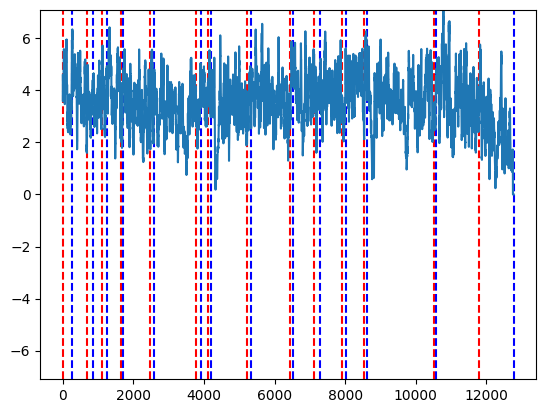

In [32]:
gobjs = downloadGenePackagesAndProcess(glist, r'tempNCBI')

print(len(gobjs))
for g in gobjs:
  runEnergetics(g)
  visualizeEnergetics(g, "Inclination", lRange=0, rRange=len(g.DNASequence))

In [ ]:
#Load each in sequence, and run spliceAI on the transcript, saving a new gene object in place of the old one with spliceAI donor and acceptor scores
def exonEnergies(geneObj : NaturalGene, windowSize = 25):
  '''Return a dictionary with lists of energy values for each position along the window number line'''
  for iso in geneObj.isoforms:
    for exon in iso.geneBody:
      s = exon['seq']
      if len(s) < windowSize * 2:
        continue
      else:
        exon['energyR'] = energyRight(s, windowSize)
        exon['energyL'] = energyLeft(s, windowSize)

def energyLeft(seq: str, windowSize):
  '''Return a list of dictionaries of energy values for each position along the window number line'''
  dinucs = [seq[i:i+2] for i in range(0, len(seq) -1, 1)]
  #print(dinucs)
  dinucEnergies = []
  for dinuc in dinucs:
    dinucEnergies.append(energeticsDict(dinuc))
  numWindows = len(seq) - windowSize
  windowEnergyAverages = []
  for i in range(0, numWindows):
    windowEnergies = [dinucEnergies[i+j] for j in range(0,windowSize)]
    windowEnergy = {}
    for key in windowEnergies[0].keys():
      windowEnergy[key] = 0
      for window in windowEnergies:
        windowEnergy[key] += window[key]
    windowEnergyAverages.append(windowEnergy)
  while len(windowEnergyAverages) < len(seq):
    windowEnergyAverages.append("N")
  return windowEnergyAverages

def energyRight(seq: str, windowSize: int):
  '''Return a list of dictionaries of energy values for each position along the window number line'''
  dinucs = [seq[i:i+2] for i in range(0, len(seq) -1, 1)]
  dinucEnergies = []
  for dinuc in dinucs:
    dinucEnergies.append(energeticsDict(dinuc))
  dinucEnergiesStandardized = []
  for i in range(0,len(seq)):
    #For the first one, just take the first energy measurement
    if i == 0:
      dinucEnergiesStandardized.append(dinucEnergies[i])
    #For the last one, just take the last energy measurement
    elif i == len(geneObj.DNASequence)-1:
      dinucEnergiesStandardized.append(dinucEnergies[i-1])
      break
    #for all others, average left and right
    else:
      #average the left and right dicts
      lDict = dinucEnergies[i-1]
      rDict = dinucEnergies[i]
      avDict = {}
      for key in lDict.keys():
        avDict[key] = (float(lDict[key]) + float(rDict[key]))/2
      dinucEnergiesStandardized.append(avDict)
  assert len(dinucEnergiesStandardized) == len(seq)


  numWindows = len(seq) - windowSize
  windowEnergyAverages = []
  k = len(seq) - 1
  while k > windowSize:
    windowEnergies = [dinucEnergies[k-j] for j in range(0,windowSize)]
    windowEnergy = {}
    for key in windowEnergies[0].keys():
      windowEnergy[key] = 0
      for window in windowEnergies:
        windowEnergy[key] += window[key]
    windowEnergyAverages.append(windowEnergy)
    k -= 1

  return windowEnergyAverages

